Aiming to reacreate the VGG 19 network. <br>
Input is 10,3,224,224 dims in the order B,C,W,H <br>
Preprocessing of images was done by subtracting the mean RGB value, computed on the training set, from each pixel. <BR>

[Architecture](https://gist.github.com/ksimonyan/211839e770f7b538e2d8#file-readme-md) <br>

In [1]:
import os
import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
from torchvision import io
from torchvision import transforms
import pandas as pd
import tqdm
import csv
import matplotlib.pyplot as plt
import numpy as np

# Prepare and load the dataset

## Data Preparation

In [2]:
# unzip the file
import zipfile
import shutil


with zipfile.ZipFile("./data/caltech256.zip","r") as zip:
    zip.extractall("./data/caltech256/")
shutil.rmtree("./data/caltech256/256_objectcategories/")
shutil.move("./data/caltech256/256_ObjectCategories/","./data/caltech256/train/")
os.mkdir("./data/caltech256/test/")

In [3]:
# train/test split
for a,_,files in os.walk("./data/caltech256/train/"):
    for f in files[:5]:
        if not os.path.exists("./data/caltech256/test/"+os.path.basename(a)+"/"):
            os.mkdir("./data/caltech256/test/"+os.path.basename(a)+"/") 
        os.rename(a+"/"+f,"./data/caltech256/test/"+os.path.basename(a)+"/"+f)

In [2]:
# train/test labels
train_labels = []
test_labels = []
categories = {}
for dirpath,_,files in os.walk("./data/caltech256/train/"):
    if len(files)>0:
        for f in files:
            path = dirpath+"/"+f
            label = int(os.path.basename(dirpath).split(".")[0])
            label_name = os.path.basename(dirpath).split(".")[1]
            categories[label] = label_name
            train_labels.append([path,label])

with open('./data/caltech256/train_labels.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(train_labels)


for dirpath,_,files in os.walk("./data/caltech256/test/"):
    if len(files)>0:
        for f in files:
            path = dirpath+"/"+f
            label = int(os.path.basename(dirpath).split(".")[0])
            test_labels.append([path,label])

# with open('./data/caltech256/test_labels.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerows(test_labels)

In [3]:
categories

{187: 'skyscraper',
 99: 'harpsichord',
 158: 'penguin',
 193: 'soccer-ball',
 246: 'wine-bottle',
 247: 'xylophone',
 183: 'sextant',
 162: 'picnic-table',
 254: 'greyhound',
 79: 'frisbee',
 111: 'house-fly',
 230: 'trilobite-101',
 218: 'tennis-racket',
 191: 'sneaker',
 233: 'tuning-fork',
 140: 'menorah-101',
 34: 'centipede',
 173: 'rifle',
 87: 'goldfish',
 206: 'sushi',
 35: 'cereal-box',
 22: 'buddha-101',
 222: 'tombstone',
 91: 'grand-piano-101',
 18: 'bowling-pin',
 155: 'paperclip',
 181: 'segway',
 9: 'bear',
 85: 'goat',
 215: 'telephone-box',
 32: 'cartman',
 257: 'clutter',
 81: 'frying-pan',
 108: 'hot-dog',
 146: 'mountain-bike',
 95: 'hamburger',
 198: 'spider',
 148: 'mussels',
 236: 'unicorn',
 196: 'spaghetti',
 241: 'waterfall',
 58: 'doorknob',
 39: 'chopsticks',
 203: 'stirrups',
 221: 'tomato',
 174: 'rotary-phone',
 182: 'self-propelled-lawn-mower',
 44: 'comet',
 150: 'octopus',
 151: 'ostrich',
 135: 'mailbox',
 129: 'leopards-101',
 20: 'brain-101',
 52: 

## Datasets and Dataloaders

Feature batch shape: torch.Size([10, 3, 224, 224])
Labels batch shape: torch.Size([10])
(224, 224, 3)
skyscraper


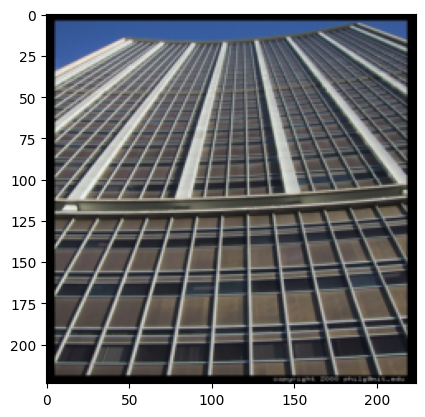

In [4]:
class ImageDatasetCustom(Dataset):
    def __init__(self,image_labels,transform=None,target_transform=None):
        self.image_labels = pd.read_csv(image_labels)
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.image_labels)
    
    def __getitem__(self, idx):
        image = io.read_image(self.image_labels.iloc[idx, 0])
        label = self.image_labels.iloc[idx, 1]
        if image.shape[0] == 1:
            image = torch.cat((image,image,image),dim=0)
        # print(image.shape)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

train_dataset = ImageDatasetCustom("./data/caltech256/train_labels.csv",
                                    transform=transforms.transforms.Resize((224,224),antialias=True))
                                
test_dataset = ImageDatasetCustom("./data/caltech256/test_labels.csv",
                                  transform=transforms.Resize((224,224),antialias=True))

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
image = np.transpose(train_features[0].numpy(), (1, 2, 0))
print(image.shape)

print(categories[train_labels[0].item()])
plt.imshow(image)
plt.show()

# Build the VGG 19 model

In [5]:
class VGGCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),

            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),

            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),

            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(in_features=294912,out_features=4096),
            nn.Linear(in_features=4096,out_features=4096),
            nn.Linear(in_features=4096,out_features=256),
        )
        self.softmax = nn.Softmax()
    
    def forward(self,X):
        return torch.softmax(self.fc(self.flatten(self.cnn(X))),dim=-1)

model = VGGCNN()
model(torch.randn((1,3,768,768)))

tensor([[0.0039, 0.0039, 0.0040, 0.0040, 0.0039, 0.0038, 0.0039, 0.0039, 0.0039,
         0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0038, 0.0039, 0.0039, 0.0039,
         0.0040, 0.0039, 0.0039, 0.0039, 0.0039, 0.0038, 0.0039, 0.0039, 0.0039,
         0.0039, 0.0039, 0.0039, 0.0039, 0.0040, 0.0039, 0.0039, 0.0039, 0.0039,
         0.0039, 0.0040, 0.0039, 0.0039, 0.0040, 0.0039, 0.0040, 0.0040, 0.0038,
         0.0040, 0.0039, 0.0039, 0.0039, 0.0039, 0.0038, 0.0039, 0.0039, 0.0039,
         0.0039, 0.0039, 0.0040, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
         0.0040, 0.0039, 0.0039, 0.0039, 0.0039, 0.0040, 0.0039, 0.0038, 0.0039,
         0.0040, 0.0039, 0.0040, 0.0039, 0.0040, 0.0039, 0.0039, 0.0038, 0.0039,
         0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
         0.0039, 0.0040, 0.0040, 0.0040, 0.0040, 0.0038, 0.0039, 0.0039, 0.0039,
         0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039,
         0.0039, 0.0040, 0.0